In [22]:
import os
import numpy as np
import pandas as pd
import nitools as nt
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from SUITPy import flatmap
import PcmPy as pcm

import selective_recruitment.plotting as plotting
import selective_recruitment.recruite_ana as ra
import selective_recruitment.globals as gl
import selective_recruitment.scripts.script_prep_sc as ss
from selective_recruitment.scripts.script_roi_differences import norm_within_category,prep_roi_comparison, plot_roi_differences


import Functional_Fusion.dataset as fdata
import Functional_Fusion.atlas_map as am
from statsmodels.stats.anova import AnovaRM  # perform F test

# import warnings
# warnings.filterwarnings('ignore')

In [23]:
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/srv/diedrichsen/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'
if not Path(wkdir).exists():
    wkdir = '/Volumes/diedrichsen_data$/data/Cerebellum/CerebellumWorkingMemory/selective_recruit'    
if not Path(wkdir).exists():
    wkdir = '/Users/jdiedrichsen/Data/wm_cerebellum/selective_recruit'

In [24]:
# sub_roi_list = ['6v', 'a9_46v', '46', 
#                 'IFJp', '6r', 'LIPv', 
#                 'MIP', 'IPS1', 'AIP', 
#                 'PFt', 'FST', 'POP4', 
#                 'SCEF', '7PL', 'v4', 
#                 'LO2', 'FEF', '6a']

sub_roi_list = ['46', '6a',
                'LIPv','MIP']

# get the indices for the selected regions
roi_left = [f"L_{name}_ROI" for name in sub_roi_list]
roi_right = [f"R_{name}_ROI" for name in sub_roi_list]
roi_list = np.concatenate([roi_left, roi_right])

In [25]:
df = ss.get_summary_data(dataset = "WMFS", 
                        ses_id = 'ses-02', 
                        atlas_space = "fs32k",
                        atlas_roi = "glasser",
                        type = "CondAll", 
                        unite_struct = False,
                        add_rest = True)

In [26]:
# get a mask for selected rois
mask_list = np.isin(df.roi_name.values, roi_list)
D = df.loc[mask_list]
# add hemi label
D["hemi"] = D["roi_name"].str[0]

# get the name
D["roi_sub"] = D["roi_name"].str.split("_", expand = True)[1]
# D, cond_map = prep_roi_comparison(D)
cond_map = D[['cond_num','cond_name']].drop_duplicates()
cond_map.sort_values(by='cond_num', inplace=True)

/tmp/ipykernel_477162/3652141797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["hemi"] = D["roi_name"].str[0]
/tmp/ipykernel_477162/3652141797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  D["roi_sub"] = D["roi_name"].str.split("_", expand = True)[1]


/home/ROBARTS/lshahsha/Documents/Projects/selective_recruitment/scripts/script_roi_differences.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[value + '_norm'] = gb.transform(lambda x: (x - x.mean()))


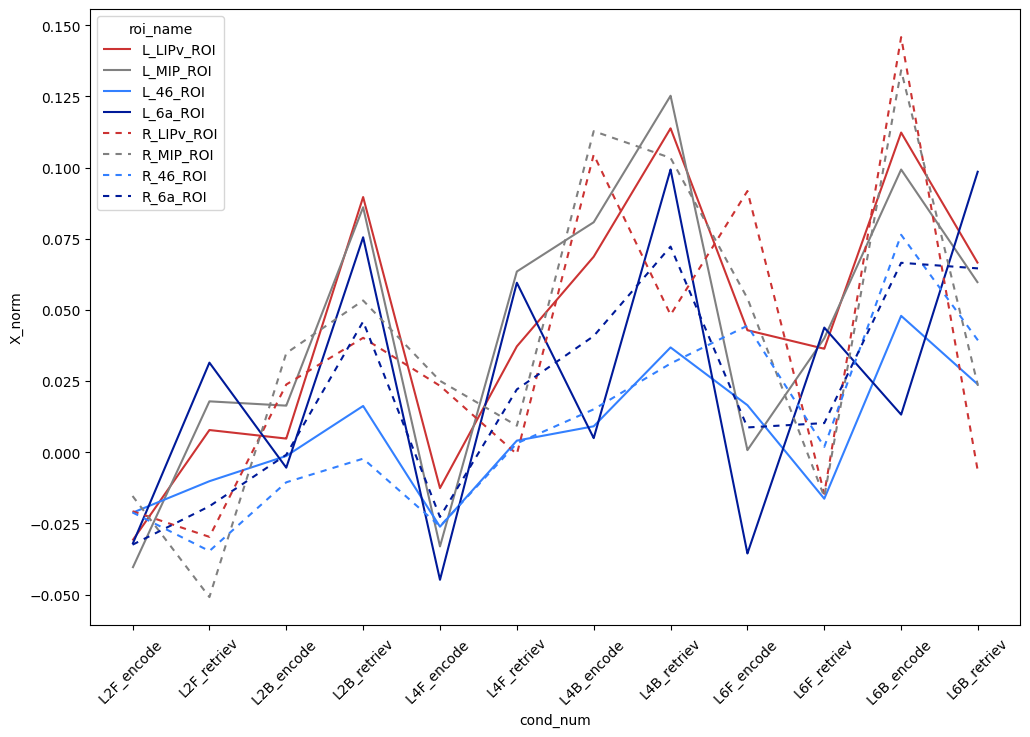

In [27]:
D = norm_within_category(D, category=['roi_name','sn'], value='X', norm='mean')
plt.figure(figsize=(12,8))
# Define styles and colors
d1 = (1,0)
d2 = (3,3)
red =(0.8,0.2,0.2)
gray = (0.5,0.5,0.5)
lb = (0.2,0.5,1.0)
db = (0.0,0.1,0.6)
pal = [red,gray,lb,db,red,gray,lb,db]

ax = sns.lineplot(data=D.loc[D.cond_name != "rest"], x = 'cond_num', y = 'X_norm', hue = 'roi_name',style='roi_name',
             palette=pal,
             dashes=[d1,d1,d1,d1,d2,d2,d2,d2],
             err_style=None)
# # Find mapping between cond_name and cond_num
ax.set_xticks(np.arange(12)+1)
l=ax.set_xticklabels(cond_map.cond_name.loc[cond_map.cond_name != "rest"].values, rotation=45)


In [28]:
anov = AnovaRM(data=D, depvar="X_norm",
                  subject='sn', within=["cond_name", "roi_name"], aggregate_func=np.mean).fit()
print(anov)

                       Anova
                   F Value  Num DF   Den DF  Pr > F
---------------------------------------------------
cond_name          29.1278 12.0000  180.0000 0.0000
roi_name            7.5000  7.0000  105.0000 0.0000
cond_name:roi_name 15.4983 84.0000 1260.0000 0.0000



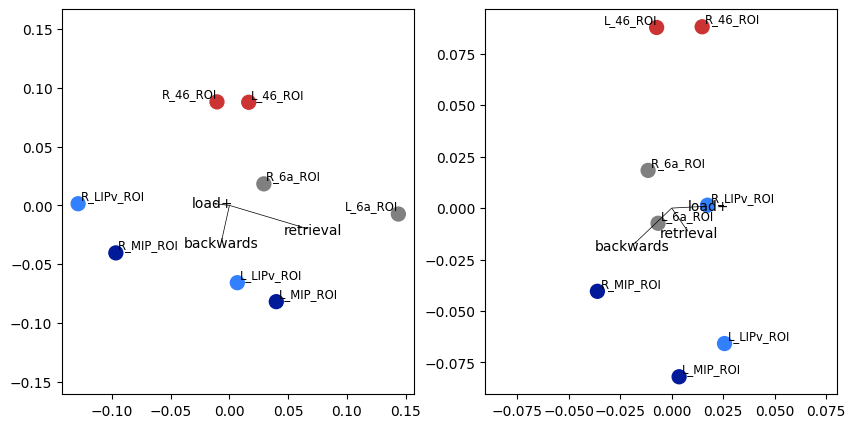

In [29]:

A = pd.pivot_table(data=D.loc[D.cond_name != "rest"],index='roi_name',columns='cond_name',values='X_norm',aggfunc=np.mean)
C=A.values
C=C/np.sqrt((C**2).sum(axis=1,keepdims=True))
B = C@C.T
K=3
W,V = plotting.calc_mds(A.values,K=K,center=True)
# phase, load, and recall
vs = np.array([[-1, 1,-1, 1,-1,1,-1,1,-1,1,-1,1],
                [-1,-1,-1,-1, 0,0, 0,0, 1,1, 1,1],
                [1,1, -1, -1, 1, 1, -1, -1,1,1, -1, -1]])
vs = vs/np.sqrt((vs**2).sum(axis=1,keepdims=True))
proj_vs = V @ vs.T


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plotting.plot_mds(W[:,0],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[:2,:],
                      v_labels = ['retrieval','load+','backwards'])
plt.subplot(1,2,2)
plotting.plot_mds(W[:,2],W[:,1],A.index,
                      colors=pal,
                      vectors=proj_vs[[2,1],:],
                      v_labels = ['retrieval','load+','backwards'])


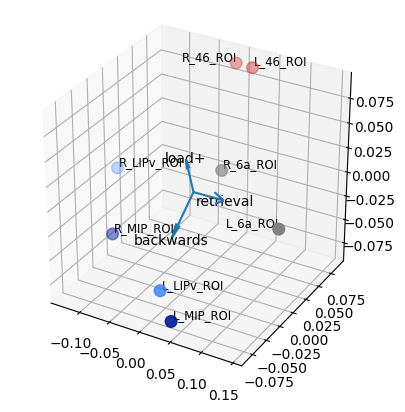

In [30]:
plotting.plot_mds3(W[:,0],W[:,1], W[:,1], 
                   A.index, 
                   colors=pal,
                   text_size = 'small', 
                   text_weight = 'regular',
                   vectors = proj_vs,
                   v_labels = ['retrieval','load+','backwards'])